## Reproduce Published MERFISH results with Starfish

Multiplexed Error Robust Fish (MERFISH) is an image based transcriptomics technique that can spatially resolve hundreds to thousands of RNA species and their expression levels in-situ. The protocol and data analysis are described in this [publication](https://science.sciencemag.org/content/348/6233/aaa6090). This notebook walks through  how to use Starfish to process the raw images from a MERFISH experiment into a spatially resolved cell by gene expression matrix. We verify that Starfish can accurately reproduce the results from the current Matlab based MERFISH [pipeline](https://github.com/ZhuangLab/MERFISH_analysis)

Please see [documentation](https://spacetx-starfish.readthedocs.io/en/stable/index.html) for detailed descriptions of all the data structures and methods used here.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import pprint
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from showit import image as show_image

from starfish import display
from starfish import data, FieldOfView
from starfish.types import Features, Axes

# from starfish.util.plot import (
#     imshow_plane, intensity_histogram, overlay_spot_calls
# )

/usr/local/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Load Data into Starfish from the Cloud

The data from one field of view correspond to 16 images from 8 hybridzation rounds (r)  2 color channels (c) one z plane (z). Each image is 2048X2048 (y,x). These data correspond to U2OS cells in culture. O(100) transcripts are barcoded for subsequent spatial resolution.

In [3]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.MERFISH(use_test_data=use_test_data)

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment._src_doc)

imgs = experiment.fov().get_image(FieldOfView.PRIMARY_IMAGES)
print(imgs)

  0%|          | 0/16 [00:00<?, ?it/s]

{ 'codebook': 'codebook.json',
  'extras': {},
  'images': {'nuclei': 'nuclei.json', 'primary': 'hybridization.json'},
  'version': '5.0.0'}


100%|██████████| 16/16 [00:00<00:00, 18.47it/s]

<starfish.ImageStack (r: 8, c: 2, z: 1, y: 2048, x: 2048)>


## Visualize codebook

The MERFISH codebook maps each barcode to a gene (or blank) feature. The Barcodes are 16 bit vectors that can be read out, for each pixel, from the 8 rounds and two color channels. The codebook contains a precise specificaton of how each of these 16 bit barcode vectors relate to the image stack

In [4]:
experiment.codebook

<xarray.Codebook (target: 140, c: 2, r: 8)>
array([[[0, 1, ..., 1, 0],
        [0, 1, ..., 0, 0]],

       [[1, 1, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [1, 0, ..., 0, 0]],

       [[1, 0, ..., 0, 0],
        [1, 0, ..., 0, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'Blank-1' 'Blank-10' 'Blank-2' 'Blank-3' ...
  * c        (c) int64 0 1
  * r        (r) int64 0 1 2 3 4 5 6 7

## Visualize raw data

A nice way to page through all this data is to use the ```display``` command. We have commented this out for now, because it will not render in Github. Instead, we simply show an image from the first round and color channel.

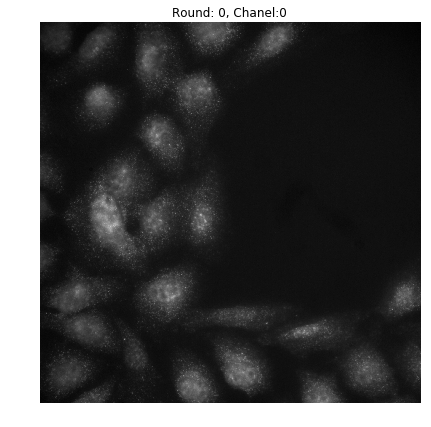

In [5]:
# Display all the data in an interactive pop-up window. Uncomment to have this version work.

# %gui qt5
# display(imgs)

# Display a single plane of data
single_plane = imgs.sel({Axes.ROUND: 0, Axes.CH: 0, Axes.ZPLANE: 0})
single_plane = single_plane.xarray.squeeze()
plt.figure(figsize=(7,7))
plt.imshow(single_plane, cmap='gray')
plt.title('Round: 0, Chanel:0')
plt.axis('off');

## Filter and scale raw data before decoding into spatially resolved gene expression

A a high pass filter is used to remove background signal, which is typically of a low frequency. This serves to remove autoflourescence, thus enhancing the ability to detect the RNA molecules.

In [6]:
from starfish.image import Filter
ghp = Filter.GaussianHighPass(sigma=3)
high_passed = ghp.run(imgs, verbose=True, in_place=False)

16it [00:01,  9.74it/s]


The below algorithm deconvolves out the point spread function (PSF) introduced by the microcope. The goal of deconvolution is to enable the resolution of more spots, especially in high transcript density regions of the data. For this assay, the PSF is well approximated by a 2D isotropic gaussian with standard deviation (sigma) of 2. This The number of iterations (here 15) is an important parameter that needs careful optimization.

In [7]:
from starfish.types import Clip
dpsf = Filter.DeconvolvePSF(num_iter=15, sigma=2, clip_method=Clip.SCALE_BY_CHUNK)
deconvolved = dpsf.run(high_passed, verbose=True, in_place=False)

16it [01:21,  5.09s/it]


The data for this assay are already registered across imaging rounds. Despite this, individual RNA molecules may still not be perfectly aligned across imaging rounds. This is crucial in order to read out a measure of the itended barcode (across imaging rounds) in order to map it to the codebook. To solve for potential mis-alignment, the images can be blurred with a 1-pixel Gaussian kernel. The risk here is that this will obfuscate signals from nearby molecules, thus potentially working against the deconvolution step from the previous cell!

In [8]:
glp = Filter.GaussianLowPass(sigma=1)
low_passed = glp.run(deconvolved, in_place=False, verbose=True)

16it [00:01, 13.04it/s]


Image intensities vary across color channels and imaging rounds. We use the author's computed scale factors to appropriately scale the data to correct for this variation. Right now we have to extract this information from the metadata and apply this transformation manually.

In [9]:
if use_test_data:
    scale_factors = {
        (t[Axes.ROUND], t[Axes.CH]): t['scale_factor']
        for t in experiment.extras['scale_factors']
    }
else:
    scale_factors = {
        (t[Axes.ROUND], t[Axes.CH]): t['scale_factor']
        for index, t in imgs.tile_metadata.iterrows()
    }

# this is a scaling method. It would be great to use image.apply here. It's possible, but we need to expose H & C to
# at least we can do it with get_slice and set_slice right now.
from copy import deepcopy
filtered_imgs = deepcopy(low_passed)

for selector in imgs._iter_axes():
    data = filtered_imgs.get_slice(selector)[0]
    scaled = data / scale_factors[selector[Axes.ROUND.value], selector[Axes.CH.value]]
    filtered_imgs.set_slice(selector, scaled, [Axes.ZPLANE])

## Visualize processed data

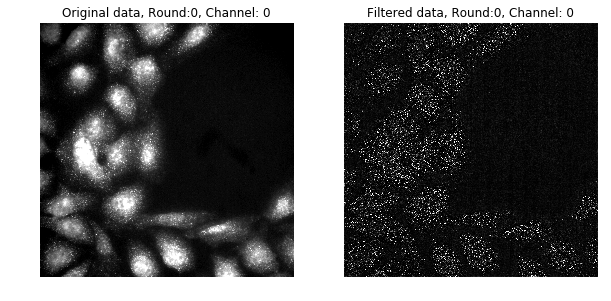

In [10]:
single_plane_filtered = filtered_imgs.sel({Axes.ROUND: 0, Axes.CH: 0, Axes.ZPLANE: 0})
single_plane_filtered = single_plane_filtered.xarray.squeeze()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(single_plane, cmap='gray', clim = list(np.percentile(single_plane.data, [5, 99])))
plt.axis('off')
plt.title('Original data, Round:0, Channel: 0')
plt.subplot(122)
plt.imshow(single_plane_filtered, cmap='gray', clim = list(np.percentile(single_plane_filtered.data, [5, 99])))
plt.title('Filtered data, Round:0, Channel: 0')
plt.axis('off');

## Decode the data into spatially resolved gene expression profiles

Here, we decode each pixel value, across all rounds and channels into the corresponding target (gene) it corresponds too. Contiguous pixels that map to the same target gene are called as one RNA molecule. Intuitively, pixel vectors are matched to the codebook by computing the euclidean distance between the pixel vector and all codewords. The minimal distance gene target is then selected. 

In [21]:
from starfish.spots import PixelSpotDecoder

psd = PixelSpotDecoder.PixelSpotDecoder(
    codebook=experiment.codebook,
    metric='euclidean', # distance metric to use for computing distance between a pixel vector and a codeword
    norm_order=2, # the L_n norm is taken of each pixel vector and codeword before computing the distance. this is n
    distance_threshold=0.5176, # minimum distance between a pixel vector and a codeword for it to be called as a gene
    magnitude_threshold=1.77e-5, # discard any pixel vectors below this magnitude
    min_area=2, # do not call a 'spot' if it's area is below this threshold (measured in pixels)
    max_area=np.inf, # do not call a 'spot' if it's area is above this threshold (measured in pixels)
)

initial_spot_intensities, prop_results = psd.run(filtered_imgs)

spot_intensities = initial_spot_intensities.loc[initial_spot_intensities[Features.PASSES_THRESHOLDS]]

100%|██████████| 68600/68600 [00:37<00:00, 1807.72it/s]
Process ForkPoolWorker-20:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1

KeyboardInterrupt: 

## Compare to results from paper

The below plot aggregates gene copy number across single cells in the field of view and compares the results to the published intensities in the MERFISH paper. Note that Starfish detects a lower number of transcripts than the authors' results. This can probably be improved by tweaking any of the above parameters.

In [ ]:
bench = pd.read_csv('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv',
                    dtype = {'barcode':object})

benchmark_counts = bench.groupby('gene')['gene'].count()
genes, counts = np.unique(spot_intensities[Features.AXIS][Features.TARGET], return_counts=True)
result_counts = pd.Series(counts, index=genes)

tmp = pd.concat([result_counts, benchmark_counts], join='inner', axis=1).values

r = np.corrcoef(tmp[:, 1], tmp[:, 0])[0, 1]
x = np.linspace(50, 2000)
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(tmp[:, 1], tmp[:, 0], 50, zorder=2)
ax.plot(x, x, '-k', zorder=1)

plt.xlabel('Gene copy number Benchmark')
plt.ylabel('Gene copy number Starfish')
plt.xscale('log')
plt.yscale('log')
plt.title(f'r = {r}');

## Visualize results

This image applies a pseudo-color to each gene channel to visualize the position and size of all called spots in a subset of the test image

100%|██████████| 1/1 [00:00<00:00, 129.80it/s]


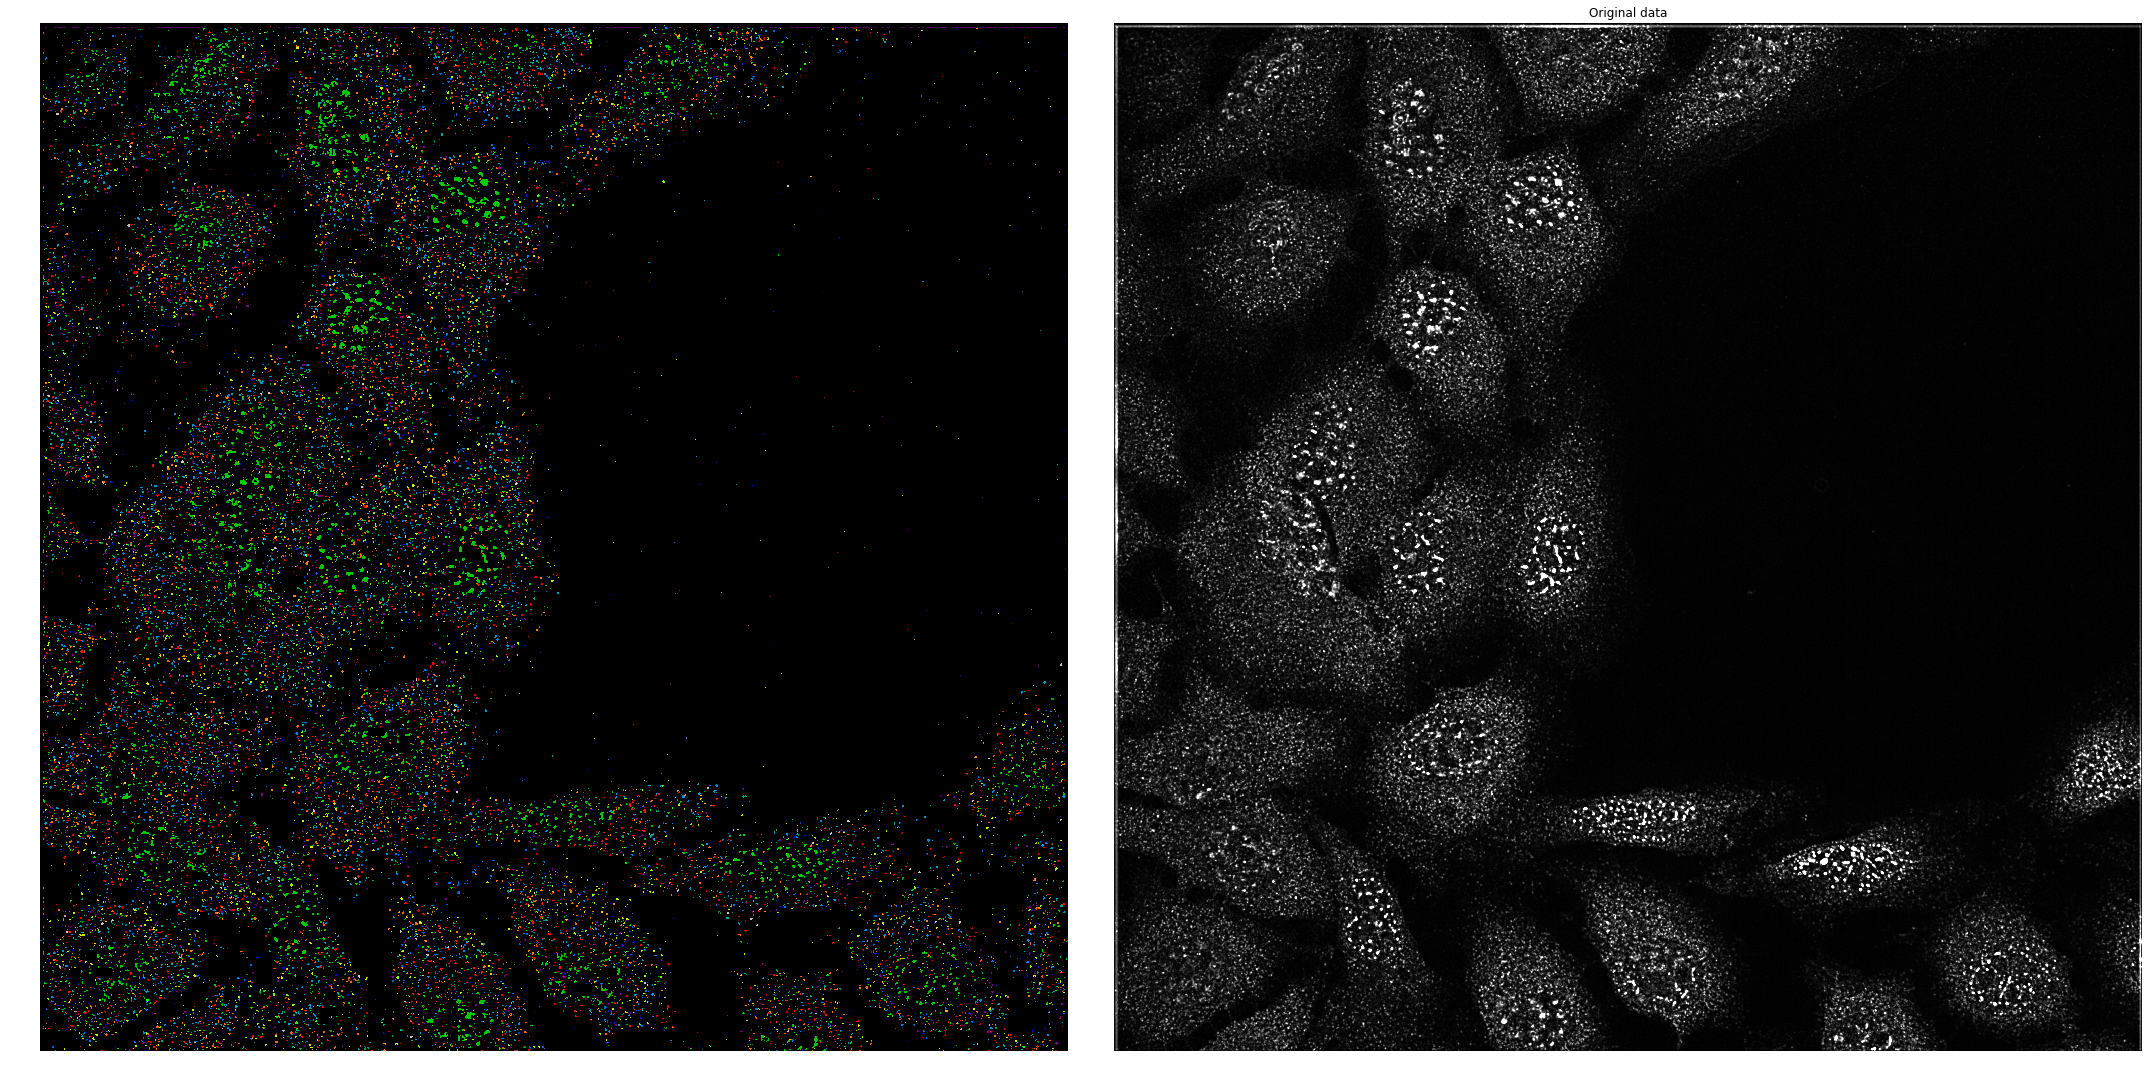

In [24]:
from scipy.stats import scoreatpercentile
import warnings

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    area_lookup = lambda x: 0 if x == 0 else prop_results.region_properties[x - 1].area
    vfunc = np.vectorize(area_lookup)
    mask = np.squeeze(vfunc(prop_results.label_image))
    show_image(np.squeeze(prop_results.decoded_image)*(mask > 2), cmap='nipy_spectral', ax=ax1)
    ax1.axes.set_axis_off()
    ax1.title('OriginalDecoded data')

    mp = filtered_imgs.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
    mp_numpy = mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
    clim = scoreatpercentile(mp_numpy, [0.5, 99.5])
    show_image(mp_numpy, clim=clim, ax=ax2)
    plt.title('Original data')


    f.tight_layout()